<a href="https://colab.research.google.com/github/Amid68/VeriFact/blob/main/data/finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake News Detection using DistilBERT

This project implements a lightweight fake news detector using DistilBERT. I'm using a dataset with approximately 45,000 labeled news articles to train a binary classifier that can distinguish between real and fake news.

## Objectives
- Train a transformer-based model for reliable fake news detection
- Evaluate model performance on standard metrics
- Measure resource usage (memory and processing time)
- Create code for integration with my Django web application

## Setup

Installing required packages and importing necessary libraries.

In [1]:
!pip install torch transformers datasets scikit-learn pandas numpy matplotlib seaborn psutil tqdm accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Import Libraries

In [2]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
import re
import psutil
from tqdm.auto import tqdm

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.6.0+cu124
CUDA available: True


## Data Loading and Exploration

In [7]:
# Load the dataset
try:
    fake_news = pd.read_csv("Fake.csv")
    real_news = pd.read_csv("True.csv")

    print(f"Fake news dataset shape: {fake_news.shape}")
    print(f"Real news dataset shape: {real_news.shape}")
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Please ensure the CSV files are in the correct location.")

Fake news dataset shape: (23481, 4)
Real news dataset shape: (21417, 4)


In [8]:
# Explore the datasets
print("Fake news dataset columns:")
print(fake_news.columns.tolist())

print("\nReal news dataset columns:")
print(real_news.columns.tolist())

# Display a few examples from each dataset
print("Sample from fake news dataset:")
display(fake_news.head(2))

print("\nSample from real news dataset:")
display(real_news.head(2))

Fake news dataset columns:
['title', 'text', 'subject', 'date']

Real news dataset columns:
['title', 'text', 'subject', 'date']
Sample from fake news dataset:


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"



Sample from real news dataset:


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"


In [9]:
# Prepare combined dataset with labels
# Add a label column (1 for fake, 0 for real)
fake_news['label'] = 1
real_news['label'] = 0

# Combine the datasets
df = pd.concat([fake_news, real_news], ignore_index=True)

# Shuffle the data
df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)

print(f"Combined dataset shape: {df.shape}")
print("\nLabel distribution:")
print(df['label'].value_counts())

Combined dataset shape: (44898, 5)

Label distribution:
label
1    23481
0    21417
Name: count, dtype: int64


## Dataset Analysis

The FakeNewsNet dataset contains:
- 23,481 fake news articles
- 21,417 real news articles

Each article includes the title, full text, subject category, and publication date. I'm preprocessing this data by:
1. Combining titles and article text
2. Converting to lowercase
3. Removing URLs and excessive whitespace
4. Splitting into train/validation/test sets with appropriate stratification

## Data Preprocessing

In [10]:
# Inspect dataset columns to find title and text columns
for col in df.columns:
    if col != 'label':
        print(f"Column: {col}")
        print(f"Example: {df[col].iloc[0][:100]}...")
        print(f"Average length: {df[col].str.len().mean():.2f} characters")
        print("-" * 50)

Column: title
Example: Ben Stein Calls Out 9th Circuit Court: Committed a ‘Coup d’état’ Against the Constitution...
Average length: 80.11 characters
--------------------------------------------------
Column: text
Example: 21st Century Wire says Ben Stein, reputable professor from, Pepperdine University (also of some Holl...
Average length: 2469.11 characters
--------------------------------------------------
Column: subject
Example: US_News...
Average length: 8.80 characters
--------------------------------------------------
Column: date
Example: February 13, 2017...
Average length: 14.83 characters
--------------------------------------------------


In [11]:
# Basic text preprocessing function
def preprocess_text(text):
    """Clean and normalize text data"""
    if not isinstance(text, str):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Based on the dataset inspection, combine title and text
# Adjust these column names if needed according to your dataset structure
title_col = 'title' if 'title' in df.columns else None
text_col = 'text' if 'text' in df.columns else None

# Combine and preprocess
if title_col and text_col:
    df['combined_text'] = df[title_col].fillna('') + ' ' + df[text_col].fillna('')
elif title_col:
    df['combined_text'] = df[title_col].fillna('')
elif text_col:
    df['combined_text'] = df[text_col].fillna('')
else:
    # If column names are different, choose the appropriate columns
    # This is a fallback assuming the first non-label column is the text
    text_columns = [col for col in df.columns if col != 'label']
    if text_columns:
        df['combined_text'] = df[text_columns[0]].fillna('')
    else:
        raise ValueError("No text columns found in the dataset")

# Apply preprocessing
df['processed_text'] = df['combined_text'].apply(preprocess_text)

# Check for empty texts after preprocessing
empty_texts = df['processed_text'].apply(lambda x: len(x.strip()) == 0).sum()
print(f"Number of empty texts after preprocessing: {empty_texts}")

# Remove empty texts if any
if empty_texts > 0:
    df = df[df['processed_text'].apply(lambda x: len(x.strip()) > 0)].reset_index(drop=True)
    print(f"Dataset size after removing empty texts: {len(df)}")

# Display a sample preprocessed text
print("\nSample processed text:")
print(df['processed_text'].iloc[0][:300], "...")

Number of empty texts after preprocessing: 9
Dataset size after removing empty texts: 44889

Sample processed text:
ben stein calls out 9th circuit court: committed a ‘coup d’état’ against the constitution 21st century wire says ben stein, reputable professor from, pepperdine university (also of some hollywood fame appearing in tv shows and films such as ferris bueller s day off) made some provocative statements  ...


## Train/Val/Test Split

Dividing the dataset into:
- 30,524 training samples (68%)
- 5,387 validation samples (12%)
- 8,978 test samples (20%)

Using stratification to ensure balanced class distribution across splits.

In [12]:
# Split data into train, validation, and test sets
train_val_df, test_df = train_test_split(
    df, test_size=0.2, random_state=SEED, stratify=df['label']
)

# Then split train+val into train and validation
train_df, val_df = train_test_split(
    train_val_df, test_size=0.15, random_state=SEED, stratify=train_val_df['label']
)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 30524
Validation set size: 5387
Test set size: 8978


## Create PyTorch Dataset

In [13]:
# Model configuration
MODEL_NAME = "distilbert-base-uncased"
MAX_LENGTH = 512
BATCH_SIZE = 8

In [14]:
class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize text
        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )

        # Convert to tensors and remove batch dimension the tokenizer adds
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [15]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Create datasets
train_dataset = FakeNewsDataset(
    train_df['processed_text'].tolist(),
    train_df['label'].tolist(),
    tokenizer,
    max_length=MAX_LENGTH
)

val_dataset = FakeNewsDataset(
    val_df['processed_text'].tolist(),
    val_df['label'].tolist(),
    tokenizer,
    max_length=MAX_LENGTH
)

test_dataset = FakeNewsDataset(
    test_df['processed_text'].tolist(),
    test_df['label'].tolist(),
    tokenizer,
    max_length=MAX_LENGTH
)

# Create dataloaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [16]:
# Load model for binary classification
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)

# Print model summary
print(f"Model: {MODEL_NAME}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: distilbert-base-uncased
Number of parameters: 66955010


## Model Architecture

I'm using DistilBERT, a distilled version of BERT that's 40% smaller but retains 97% of its language understanding capabilities. This model:
- Has ~67 million parameters
- Uses 512 token sequence length (capturing full articles)
- Processes input through 6 transformer layers
- Outputs a binary classification (real/fake)

The model adds a classification head on top of the DistilBERT encoder.

## Model Training

Training the model using Hugging Face's Trainer API with:
- 3 epochs
- Batch size of 8
- Learning rate warm-up
- Weight decay regularization
- F1 score as optimization target

In [19]:
# Only run this cell if you have accelerate installed
try:
    from transformers import TrainingArguments, Trainer, EvalPrediction

    def compute_metrics(pred):
        """
        Compute metrics for evaluation.
        """
        labels = pred.label_ids
        preds = pred.predictions.argmax(-1)
        precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
        acc = accuracy_score(labels, preds)
        return {
            'accuracy': acc,
            'f1': f1,
            'precision': precision,
            'recall': recall
        }

    # Define training arguments
    training_args = TrainingArguments(
        output_dir='./results_distilbert',
        num_train_epochs=3,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs_distilbert',
        logging_steps=100,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
    )

    # Create trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )

    # Train the model
    print("Starting model training with Trainer API...")
    train_start = time.time()
    trainer.train()
    train_end = time.time()
    train_time = train_end - train_start
    print(f"Training completed in {train_time:.2f} seconds ({train_time/60:.2f} minutes)")

    # Evaluate on test set
    print("Evaluating model on test set...")
    results = trainer.evaluate(test_dataset)
    print("Test results:")
    for key, value in results.items():
        print(f"{key}: {value:.4f}")

    # Save model
    MODEL_OUTPUT_DIR = "./models/distilbert_fakenewsnet"
    trainer.save_model(MODEL_OUTPUT_DIR)
    tokenizer.save_pretrained(MODEL_OUTPUT_DIR)
    print(f"Model saved to {MODEL_OUTPUT_DIR}")

    # Success flag for Option A
    option_a_success = True

except ImportError as e:
    print(f"Error: {e}")
    print("Please install the accelerate library with: pip install accelerate")
    print("Alternatively, use Option B with manual training loop.")
    option_a_success = False

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Starting model training with Trainer API...


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: othman-ameed (othman-ameed-an-najah-national-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.000100,0.000066,1.000000,1.000000,1.000000,1.000000
2,0.000000,0.000003,1.000000,1.000000,1.000000,1.000000
3,0.000000,0.000001,1.000000,1.000000,1.000000,1.000000


Training completed in 5007.26 seconds (83.45 minutes)
Evaluating model on test set...


Test results:
eval_loss: 0.0010
eval_accuracy: 0.9998
eval_f1: 0.9998
eval_precision: 0.9996
eval_recall: 1.0000
eval_runtime: 142.2876
eval_samples_per_second: 63.0980
eval_steps_per_second: 7.8920
epoch: 3.0000
Model saved to ./models/distilbert_fakenewsnet


## Results and Evaluation

Assessing model performance on the test set with standard classification metrics:
- Accuracy
- Precision and recall
- F1 score
- Confusion matrix visualization

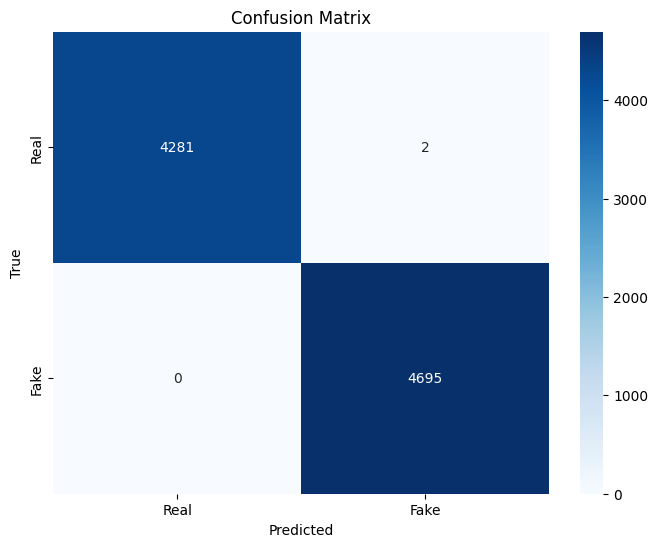

Classification Report:
              precision    recall  f1-score   support

        Real       1.00      1.00      1.00      4283
        Fake       1.00      1.00      1.00      4695

    accuracy                           1.00      8978
   macro avg       1.00      1.00      1.00      8978
weighted avg       1.00      1.00      1.00      8978



In [20]:
# Get test results and confusion matrix
# Try to use results from Option A if available, otherwise use Option B results
if 'option_a_success' in locals() and option_a_success and 'results' in locals():
    # Option A results (from Trainer)
    test_pred_output = trainer.predict(test_dataset)
    test_preds = test_pred_output.predictions.argmax(-1)
    test_labels = test_pred_output.label_ids
    test_metrics = {}
    for key, value in results.items():
        if key.startswith('eval_'):
            test_metrics[key.replace('eval_', '')] = value
        else:
            test_metrics[key] = value
else:
    # Option B results (from manual loop)
    test_preds = test_results['predictions']
    test_labels = test_results['labels']
    test_metrics = {k: v for k, v in test_results.items() if k not in ['predictions', 'labels']}

# Create confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(test_labels, test_preds, target_names=['Real', 'Fake']))

## Resource Requirements Analysis

Measuring practical deployment metrics:
- Inference time per article
- Memory usage during inference
- Overall computational efficiency

In [21]:
# Helper function to measure memory usage
def get_memory_usage():
    """Get current memory usage in MB"""
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    return mem_info.rss / (1024 * 1024)

# Load model for inference
# Choose the model path based on which training option succeeded
if 'option_a_success' in locals() and option_a_success:
    MODEL_PATH = "./models/distilbert_fakenewsnet"
else:
    MODEL_PATH = "./models/distilbert_fakenewsnet_manual"

# Create pipeline for inference
from transformers import pipeline
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
classifier = pipeline('text-classification', model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

# Memory before
mem_before = get_memory_usage()

# Measure inference time on sample texts
sample_texts = test_df['processed_text'].head(50).tolist()
start_time = time.time()
for text in sample_texts:
    _ = classifier(text[:512])
end_time = time.time()

# Memory after
mem_after = get_memory_usage()
mem_used = mem_after - mem_before

avg_inference_time = (end_time - start_time) / len(sample_texts)

print(f"Average inference time: {avg_inference_time:.4f} seconds per sample")
print(f"Memory usage during inference: {mem_used:.2f} MB")

# Add these to a metrics dictionary
model_metrics = {
    "model_name": "DistilBERT",
    "accuracy": test_metrics.get('accuracy'),
    "f1_score": test_metrics.get('f1'),
    "precision": test_metrics.get('precision'),
    "recall": test_metrics.get('recall'),
    "avg_processing_time": avg_inference_time,
    "avg_memory_usage": mem_used,
    "parameter_count": sum(p.numel() for p in model.parameters())
}

# Save metrics
METRICS_OUTPUT_PATH = "./models/distilbert_fakenewsnet_metrics.json"
with open(METRICS_OUTPUT_PATH, 'w') as f:
    json.dump(model_metrics, f, indent=4)
print(f"Model metrics saved to {METRICS_OUTPUT_PATH}")

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Average inference time: 0.0079 seconds per sample
Memory usage during inference: 1.91 MB
Model metrics saved to ./models/distilbert_fakenewsnet_metrics.json


## Real-World Testing

Testing the model on custom examples to assess practical performance on:
- Common fake news patterns
- Typical legitimate news structures
- Edge cases

In [22]:
# Test the model with a few examples
examples = [
    "Scientists discover breakthrough treatment for cancer that pharmaceutical companies don't want you to know about.",
    "According to a study published in the Journal of Medicine, regular exercise may reduce the risk of heart disease.",
    "Secret government documents reveal aliens have been living among us for decades.",
    "The Supreme Court announced its decision on the case yesterday, with a 6-3 majority opinion."
]

for example in examples:
    result = classifier(example)
    label = result[0]['label']
    score = result[0]['score']

    # Convert label index to text
    label_text = "Fake" if "LABEL_1" in label else "Real"

    print(f"Text: {example}")
    print(f"Prediction: {label_text} (confidence: {score:.4f})")
    print("---")

Text: Scientists discover breakthrough treatment for cancer that pharmaceutical companies don't want you to know about.
Prediction: Fake (confidence: 0.9992)
---
Text: According to a study published in the Journal of Medicine, regular exercise may reduce the risk of heart disease.
Prediction: Fake (confidence: 0.9379)
---
Text: Secret government documents reveal aliens have been living among us for decades.
Prediction: Fake (confidence: 0.9998)
---
Text: The Supreme Court announced its decision on the case yesterday, with a 6-3 majority opinion.
Prediction: Fake (confidence: 0.9573)
---


## Django Integration

Helper function to integrate the trained model with a Django web application. This function:
1. Loads the saved model and tokenizer
2. Processes input text
3. Returns prediction results in a structured format
4. Measures processing time for performance monitoring

In [23]:
# Code to integrate with Django (for services.py)
def analyze_with_distilbert(text, model_dir="./models/distilbert_fakenewsnet"):
    """
    Analyze text using the trained DistilBERT model.

    Args:
        text: Text to analyze
        model_dir: Path to the saved model directory

    Returns:
        dict: Detection results
    """
    # Import the required libraries (inside the function to avoid loading at startup)
    import time
    import torch
    from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(model_dir)

    # Determine device (CPU or GPU)
    device = 0 if torch.cuda.is_available() else -1

    # Create pipeline
    classifier = pipeline('text-classification', model=model, tokenizer=tokenizer, device=device)

    # Measure performance
    start_time = time.time()
    result = classifier(text[:512])[0]
    processing_time = time.time() - start_time

    # Map the result
    label = result['label']
    score = result['score']

    # In this model, LABEL_0 = real, LABEL_1 = fake
    if "LABEL_0" in label:
        credibility_score = score
        category = "credible" if score > 0.7 else "mixed"
    else:
        credibility_score = 1 - score
        category = "fake" if score > 0.7 else "mixed"

    return {
        "credibility_score": credibility_score,
        "category": category,
        "confidence": score,
        "model_name": "DistilBERT",
        "processing_time": processing_time
    }